Import libraries

In [88]:
from skimage import io, color, img_as_ubyte
from skimage.filters import rank
from skimage.morphology import disk
from skimage.segmentation import watershed, relabel_sequential
from scipy import ndimage as ndi
from skimage.measure import regionprops, label
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from skimage.util import random_noise

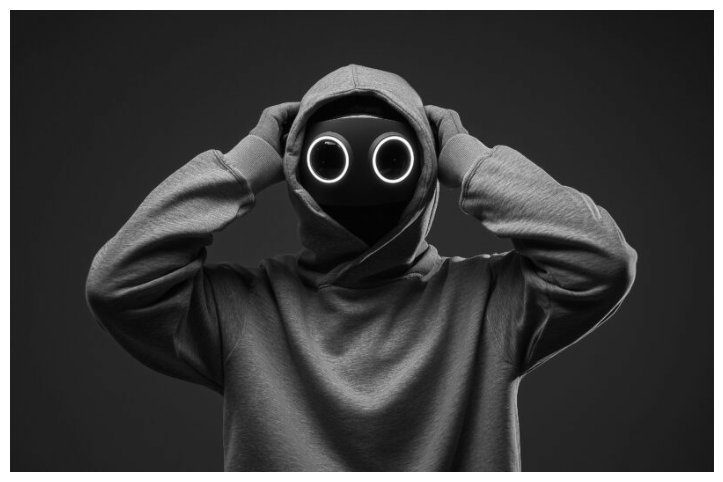

In [78]:
image_rgba = io.imread('../skib.jpg')
image_rgb = image_rgba[:, :, :3]
image_gray = color.rgb2gray(image_rgb)
image = img_as_ubyte(image_gray)
plt.figure(figsize=(10, 6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

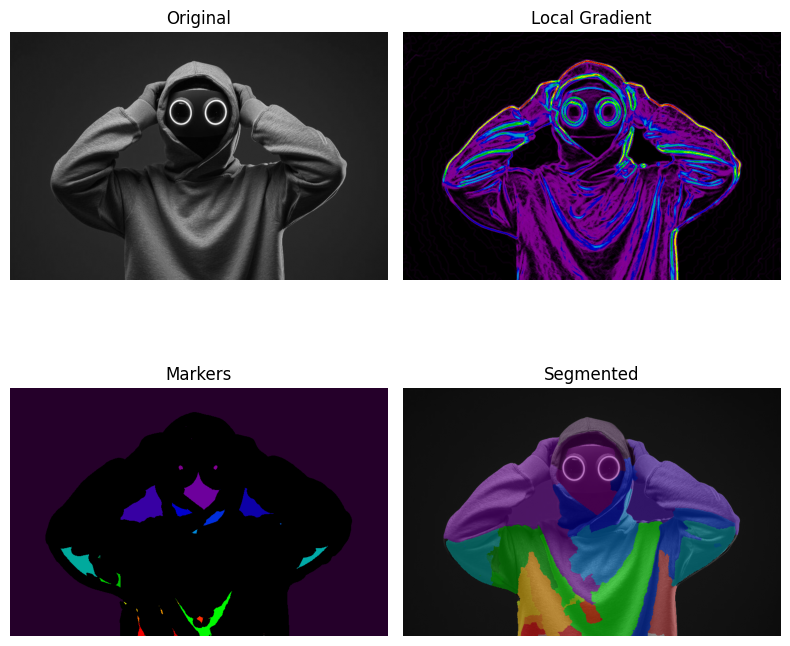

In [124]:
def segment_image(image, median_disk, markers_disk, gradient_disk):
# === Denoise and compute markers ===
  denoised = rank.median(image, disk(median_disk))
  markers = rank.gradient(denoised, disk(markers_disk)) < 10
  markers = ndi.label(markers)[0]

  # === Compute local gradient and apply watershed ===
  gradient = rank.gradient(denoised, disk(gradient_disk))
  labels = watershed(gradient, markers)

  # === Visualization: Watershed steps ===
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True)
  ax = axes.ravel()

  ax[0].imshow(image, cmap=plt.cm.gray)
  ax[0].set_title("Original")

  ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
  ax[1].set_title("Local Gradient")

  ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
  ax[2].set_title("Markers")

  ax[3].imshow(image, cmap=plt.cm.gray)
  ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=0.5)
  ax[3].set_title("Segmented")

  for a in ax:
      a.axis('off')

  fig.tight_layout()
  plt.show()
  return labels

labels = segment_image(image, 5, 10, 2)


Found 54 regions


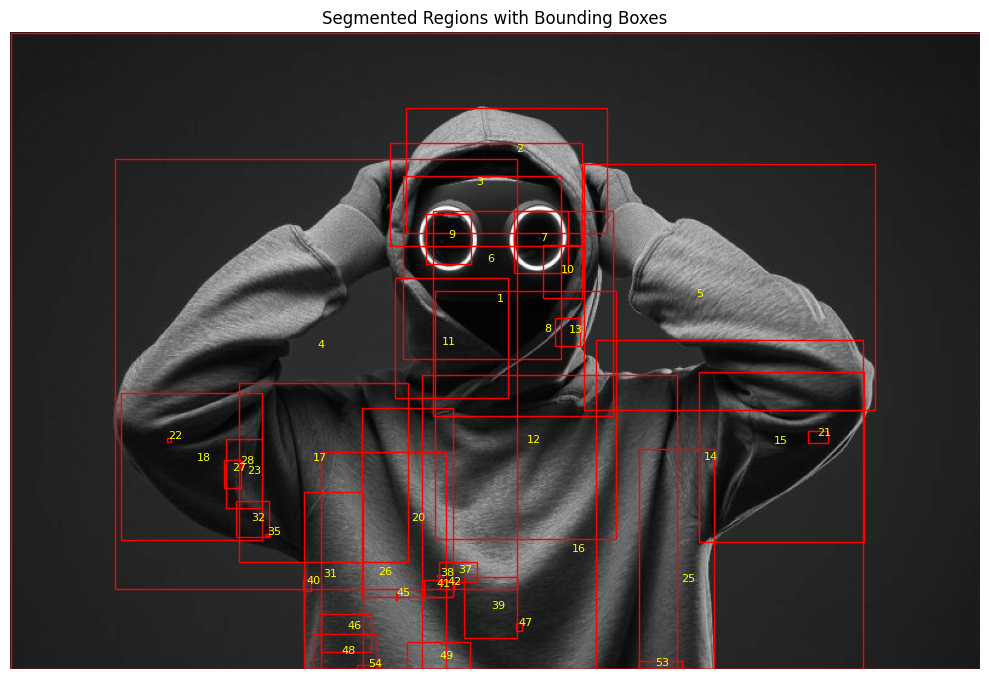

In [135]:
# === Region Properties Analysis ===
label_image = label(labels)
props = regionprops(label_image)

print(f"Found {len(props)} regions")

# Plot regions with bounding boxes and centroids
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image, cmap='gray')
ax.set_title("Segmented Regions with Bounding Boxes")

region_data = []
for region in props:
    if region.area < 5:
        continue  # skip tiny noise

    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)

    cy, cx = region.centroid
    ax.text(cx, cy, f"{region.label}", color='yellow', fontsize=8)

    region_data.append({
        "Label": region.label,
        "Area": region.area,
        "Eccentricity": region.eccentricity,
        "Centroid": region.centroid
    })

ax.axis('off')
plt.tight_layout()
plt.show()


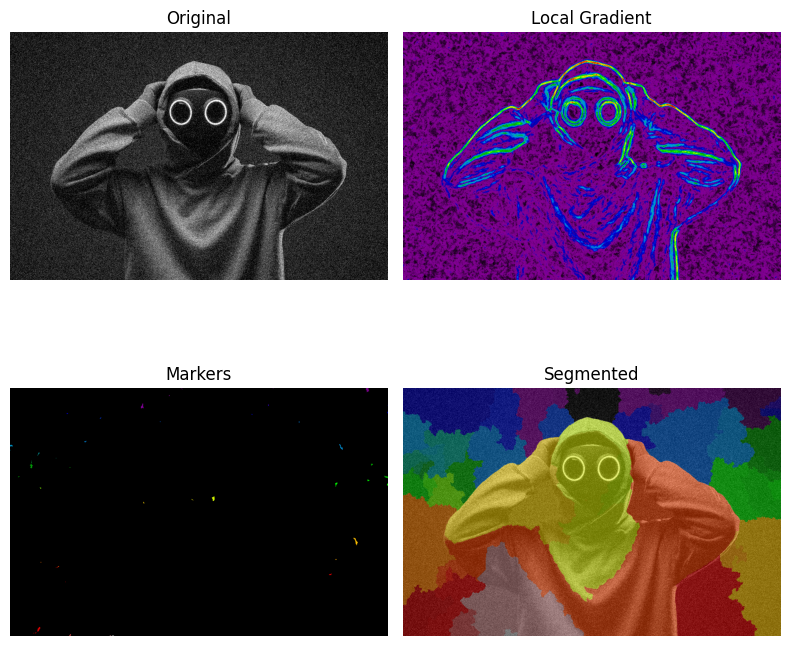

In [136]:
#noisy_image = random_noise(image, mode='s&p', amount=0.09)
noisy_image = random_noise(image, mode='gaussian', var=0.01)
noisy_image = img_as_ubyte(noisy_image)
noisy_labels = segment_image(noisy_image, 5, 10, 2)

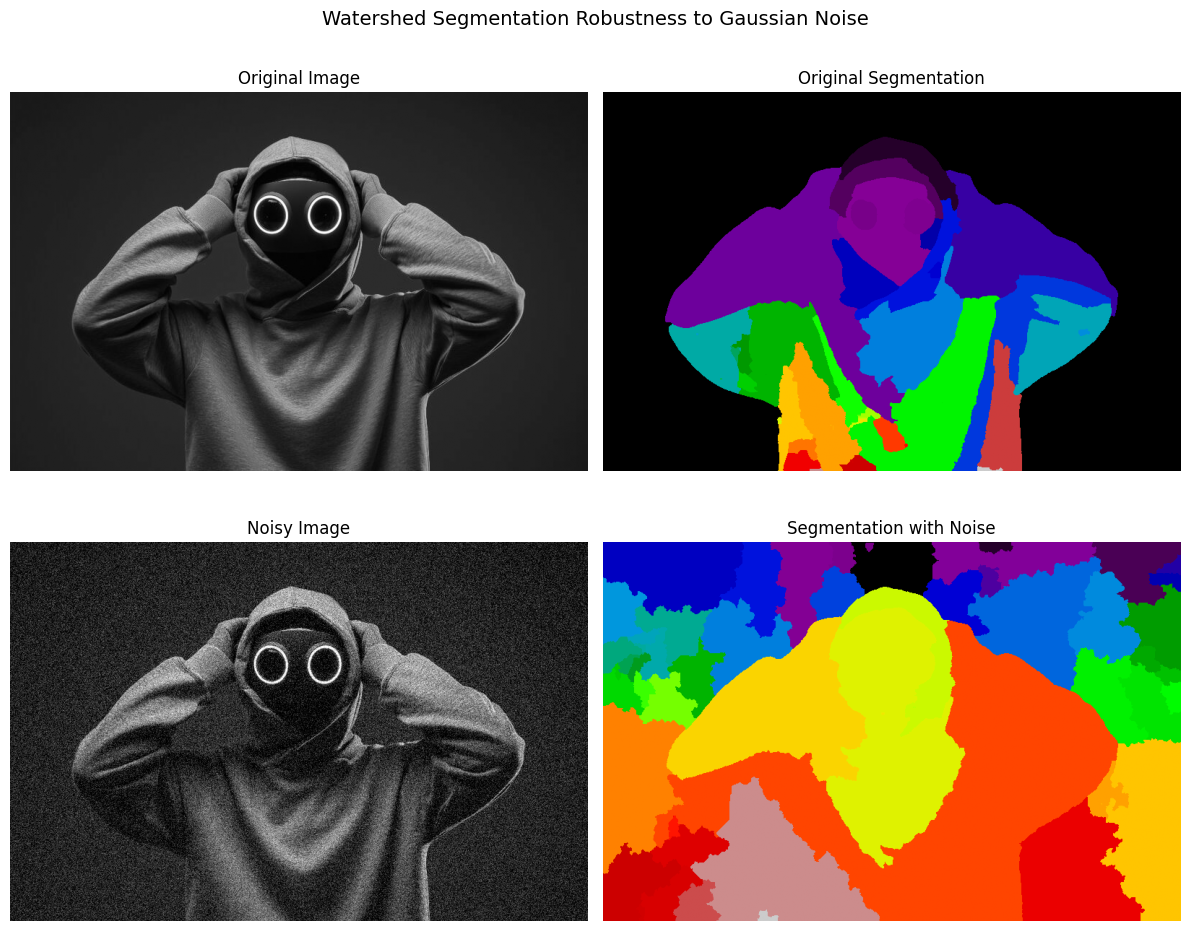

In [137]:
# === 3. Display comparison ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")

ax[1].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Original Segmentation")

ax[2].imshow(noisy_image, cmap='gray')
ax[2].set_title("Noisy Image")

ax[3].imshow(noisy_labels, cmap=plt.cm.nipy_spectral)
ax[3].set_title("Segmentation with Noise")

for a in ax:
    a.axis('off')

plt.suptitle("Watershed Segmentation Robustness to Gaussian Noise", fontsize=14)
plt.tight_layout()
plt.show()


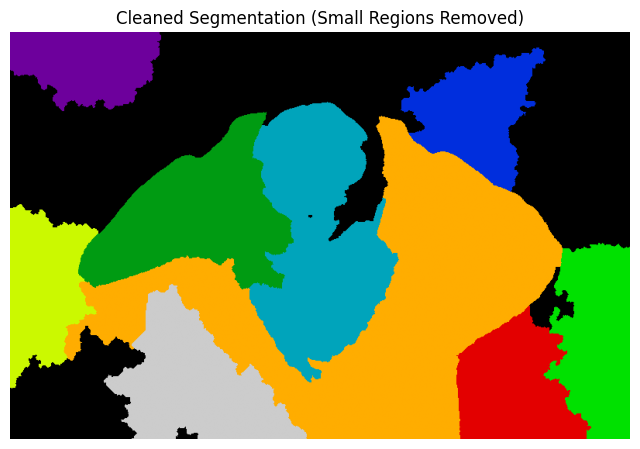

In [141]:
def remove_small_regions(label_image, min_area=100):
    """
    Remove segments smaller than min_area.
    """
    cleaned = np.zeros_like(label_image)
    current_label = 1

    for region in regionprops(label_image):
        if region.area >= min_area:
            cleaned[label_image == region.label] = current_label
            current_label += 1

    # Optional: relabel sequentially (e.g., 1, 2, 3, ...)
    cleaned, _, _ = relabel_sequential(cleaned)
    return cleaned
labels_cleaned = remove_small_regions(noisy_labels, min_area=10000)
#labels_cleaned = remove_small_regions(labels, min_area=5000)
# === Visualize cleaned result ===
plt.figure(figsize=(8, 6))
plt.imshow(labels_cleaned, cmap="nipy_spectral")
plt.title("Cleaned Segmentation (Small Regions Removed)")
plt.axis("off")
plt.show()